# Deep Learning: Homework 2

-------------------------------


**Name:** Your Name

**SN:** Your Student Number

-----------------------------------


**Start date:** *12th Feb 2018*

**Due date:** *5th March 2018, 11:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_DL_hw2.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results ( table in Q2) and all answers to the understanding/analysis results questions (Q1 and Q3), into a PDF. Name convention: **studentnumber_DL_hw2.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 7 pg ** (w/o the bonus question).

------------------------------------------------

## MNIST as a sequence
In this assignment we will be using the [MNIST digit dataset](https://yann.lecun.com/exdb/mnist/). The dataset contains images of hand-written digits ($0-9$), and the corresponding labels. The images have a resolution of $28\times 28$ pixels. This is the same dataset as in Assignment 1, but we will be using this data a bit differently this time around. Since this assignment will be focusing on recurrent networks that model sequential data, we will be looking at each image as a sequence: the networks you train will be "reading" the image one row at a time, from top to bottom (we could even do pixel-by-pixel, but in the interest of time we'll do row-by-row which is faster).  Also, we will work with a binarized version of MNIST -- we constrain the values of the pixels to be either $0$ or $1$. You can do this by applying the method `binarize`, defined below, to the raw images.

<img src="https://github.com/bodono/files/blob/master/mnist_as_sequence.png?raw=true">

* We take the MNIST images, binarise them, and interpret them as a sequence of pixels from top-left to bottom-right. ("Task 2" refers to the next homework, wherein you will be using the sequence for pixel prediction).

## Recurrent Models for MNIST

As discussed in the lectures, there are various ways and tasks for which we can use recurrent models. A depiction of the most common scenarios is available in the Figure below. In this assignment and the following one we will look at two of these forms: **many-to-one** (sequence to label/decision) and the **many-to-many** scenario where the model receives an input and produces an output at every time step. You will use these to solve the following tasks: i) classification (*this homework*), ii) pixel prediction (*next homework*) and iii) in-painting (*next homework*).

<img src="https://github.com/bodono/files/blob/master/rnn_models.png?raw=true">
* ([Figure adapted from Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)). You will be implementing variants of *many-to-one* for classification (in this homework), and *many-to-many* for prediction (in the next homework).


## Q1: Understanding LSTM vs GRU (30 pts)
Before going deeper into your practical tasks, take some time to revise and make sure you understand the two major types of recurrent cells you will be using in this assignment: Long-Short Term Memory Units (LSTM) first introduced by Hochreiter and Schmidhuber [1997] and the more recent Gated Recurrent Units (GRU) by Cho et al. [2014]. Once you have done this, answer the following questions:

1. Can LSTMs (and respectively GRUs) just store the current input in the state ($c_t$ for LSTM and $h_t$ for GRU, in the class notation) for the next step? If so, give the gates activation that would enable this behaviour. If not, explain why not. [10 pts]
2. Can LSTMs (and respectively GRUs) just store a previous state into the current state and ignore the current input? If so, give the gates' activation that would enable this. If not, explain why not. [10 pts]
3. Are GRUs a special case of LSTMs? If so, give the expression of the GRU gates in term of LSTM's gates ($o_t, i_t, f_t$). If not, give a counter-example. Assume here the same input. [10 pts]

**Word limit: ** 1000 words or less

1. For LSTMs this is not possible past the first cell, this is due to the concatenation of the $h_{t-1}$ to the input value $x_t$, this is done before all further calculations are completed. This means that the state $c_t$ is dependant on both $h_{t-1}$ and input $x_t$, meaning that you cannot just store the input without $h_{t-1} = 0$. For GRU the same is also true, this can be seen in the gate updates, $$z_t = \sigma (W_z . [h_{t-1}, x_t])$$ $$r_t = \sigma (W_r . [h_{t-1}, x_t])$$ $$\tilde{h_t} = tanh(W . [r_t * h_{t-1}, x_t]) $$ Since they are all dependant on $h_{t-1}$ the cell cannot store just the input $x_t$ easily. Since $h_t$ is also dependant on $\tilde{h_t}$, none of the gates can just store this information from $x_t$. 

2. For GRU it is easy to just repeat the previous output, this is seen in the equation $h_t = (1 - z_t)* h_{t-1} + z_t* \tilde{h_t}$. If we wish to keep the state(or output as they are the same for GRUs) the same, $z_t = 1$ would give us $h_t = h_{t-1} $. This means that we have ignored the current input and stored the previous state/output as asked. This is harder for LSTMs, however by blocking off or saturating the remember gates ($i_t = 0$) and forget gates ($f_t = 0$) to 0 we let no new information into the state. Thus, we just have $c_t = c_{t-1}$, as required.

3. No they are not. An example of this is that GRUs can repeat the previous output very simply by just setting the input gate ($x_t$) = 0, this is not possible for the LSTM because the previous output is passed through 2 tanh gates on the way through the cell before having an effect of the current output. While it is possible for the gates to return the values needed to repeat the previous output (although this could be very hard to achieve) this is impossible for an LSTM to achieve while it's quite simple for a GRU to achieve. Since we need to make the tanh gates in the LSTM equal to a linear function this requires extra attention and work with the LSTM, meaning that the GRU is not a special case of the LSTM.

## Q2: Implementation. Line-by-Line MNIST Classification (50 pts)
In this part you will train a number of many-to-one recurrent models that takes as input: an image (or part of an image) as a sequence (row by row) and after the last input row produces, as output, a probability distribution over the $10$ possible labels ($0-9$). The models will be trained using a cross-entropy loss function over these output probabilities.

### Optimization
Use the Adam optimizer (with default settings other than the learning rate) for training.

**[Optional]** Sometimes dropout has been shown to be beneficial in training recurrent models, so feel free to use it or any other form of regularization that seems to improve performance. It might be also worth trying out batch-normalization. [Reference](https://arxiv.org/pdf/1603.09025.pdf).

### Models: Your models will have the following structure:
1. [(Red Block)] The *input* (current binarised row of pixels) can be fed directly into the recurrent connection without  much further pre-processing. The only thing you need to do is have an affine transformation to match the dimensionality of the recurrent unit, i.e. one of $(32, 64, 128)$.
2. [(Blue Block)] The *output* (probabilities over the 10 classes) is produced by looking at the last output of the recurrent units, transforming them via an affine transformation.
3. [(Green Block)] For the *recurrent* part of the network, please implement and compare the following architectures:
    * LSTM with 32, 64, 128 units. [15 pts]
    * GRU with 32, 64, 128 units. [15 pts]
    * stacked LSTM: 3 recurrent layers with 32 units each. [10 pts]
    * stacked GRU: 3 recurrent layers with 32 units each. [10 pts]

Your network should look like:
\begin{equation}
\textrm{Input} \Rightarrow \textrm{RNN cell} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Output}
\end{equation}
You might find the function `tf.nn.dynamic_rnn` useful.

### Hyper-parameters 
For all cases train the model with these hyper-parameter settings:

- *num_epochs*=10, *learning_rate*=0.001, *batch_size*=256, *fully_connected_hidden_units=64*

With these hyper-parameters you should be comfortably above $95\%$ test set accuracy on all tasks. (Feel free to try other settings, there are certainly better choices, but please report the results with these exact hyper-parameters). Please report the *cross-entropy* and the *classification accuracy* for the *test set* of the models trained. Use the `plot_summary_table` method below to format the table.


## Q3: Analyse the results (20 pts + 10 pts)

1. How does this compare with the results you obtained in the first assignment(DL1), when training a model that "sees" the entire image at once? Explain differences. [5 pts]

2. Let us take a look closer look at one of the trained models: say GRU (32). Plot the outputs of the RNN layer and hidden state over time. In particular, look at the first 3-5 time steps. Plot the input image along side. 
You can use ```python
plt.imshow(output_GRU_over_time)
```
for these, where ```output_GRU_over_time.shape``` is (T=28,hidden_units) dimensional. What do you observe? Show at least one pair of these plots to support your observation(s). [5 pts]
3. Now, look at the last 3-5 time steps. What do you observe? When is the classification decision made? To validate your answer to the second part of the question, provide the classification predictions for the last 5 time steps -- that is, pretend whatever the output of the GRU is at that time step is in fact the last output in the computation, and feed that into the classification mapping. [10 pts] 

**Word limit:** 500 words or less 


**[Bonus]** Let's looking inside the computation. Take one of the previous LSTM models (for simplicity pick one of the one-layer recurrence models) and track the status of the gates ($o_t, i_t, f_t$) over time. Note that if you used the provided RNNCell wrappers (BasicLSTMCell and co) in tensorflow, these will keep this information hidden, so you will need to implement your own version of this recurrence layer, or mirror the one in tensorflow, but now exposing these hidden variables. A bit of warning: this is not trivial and will require some thinking on the coding side, but it will also provide you with a more informative way of visulazing the inner computation.  [10 pts]

**Word limit:** 300 words or less 

## Answers to Q3

1. The results from the RNN's have better accuracy than the assignment 1 models. However they seem to have an upper bound to the results (98%) whilst the CNN (model 4) in assignment 1 was able to reach a higher accuracy. They also reached the high accuracy at a low number of epochs, compared to the assignment 1 models, often reach 90% accuracy in 3 epochs. The reason for the higher accuracy compared to the MLPs in DL1 could be due to the similar model and Adam Optimiser compared to SGD, this makes a huge difference in terms of convergence of to the higher accuracy in a shorter number of epochs.

2. The output of the RNN over the initial 5 time steps has a lot less confidence its' predictions, this is shown as the rows have similar colour across all of the pixels in the row. They are not well defined and not useful for classification. In the analysis of results I have included a classification and training on the 5th time step. The accuracy of this model is very low and doesn't converge to any particular accuracy.

3. The final 5 time steps of the RNN provide more confidence in the classification. The classification is made on the final output time step, however the confidence increases throughout the time steps. You can see the change in the gradients of the black/white scale, in the first few layers the output was greyed and unclear, while the final layer has more definite colours showing higher confidence in the classification. In the analysis of results we can see that when you vary the output layer between the last time step and the 5th last time step, the accuracy of the model does not change a lot. This means that the last 5 or so layers should be interchangable for both training and testing, this supports the hypothesis that the confidence of the classifcation is a lot higher in the final steps. 

# Imports and utility functions (do not modify!)

In [ ]:
# Import useful libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# Binarize the images
def binarize(images, threshold=0.1):
  return (threshold < images).astype('float32')

# Import dataset with one-hot encoding of the class labels.
def get_data():
  return input_data.read_data_sets("MNIST_data/", one_hot=True)

# Placeholders to feed train and test data into the graph.
# Since batch dimension is 'None', we can reuse them both for train and eval.
def get_placeholders():
  x = tf.placeholder(tf.float32, [None, 784])
  y = tf.placeholder(tf.float32, [None, 10])
  return x, y

# Generate summary table of results. This function expects a dict with the
# following structure: keys of 'LSTM' or 'GRU' and the values for each key are a
# list of tuples consisting of (test_loss, test_accuracy), and the list is
# ordered as the results from 32 units, 64 units, 128 units, 3 x 32 units, i.e.:
# {
#  'LSTM': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
#  'GRU': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
# }
def plot_summary_table(experiment_results):
  # Fill Data.
  cell_text = []
  columns = ['(1 layer, 32 units)', '(1 layer, 64 units)', '(1 layer, 128 units)', '(3 layers, 32 units)']
  for k, v in experiment_results.items():
    rows = ['Test loss', 'Test accuracy']
    cell_text=[[],[]]
    for (l, _) in v:
      cell_text[0].append(str(l))
    for (_, a) in v:
      cell_text[1].append(str(a))

    fig=plt.figure(frameon=False)
    ax = plt.gca()
    the_table = ax.table(
      cellText=cell_text,
      rowLabels=rows,
      colLabels=columns,
      loc='center')
    the_table.scale(2, 8)
    # Prettify.
    ax.patch.set_facecolor('None')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(-0.73, 0.9, k, fontsize=18)

# Train Models

Generate summary table of results. This function expects a dict with the
following structure: keys of 'LSTM' or 'GRU' and the values for each key are a
list of tuples consisting of (test_loss, test_accuracy), and the list is
ordered as the results from 32 units, 64 units, 128 units, 3 x 32 units, i.e. expected dictionary (final performace only):

```python
{
  'LSTM': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
  'GRU': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
}
```

In [ ]:
# Training Parameters
learning_rate = 0.001
num_epochs = 10
batch_size=256
fully_connected_hidden_units=64
num_input = 28
timesteps = 28
num_classes = 10
settings = [(32, 'LSTM', 1), (32, 'GRU', 1), (64, 'LSTM', 1), (64, 'GRU', 1), 
            (128, 'LSTM', 1), (128, 'GRU', 1), (32, 'LSTM', 3), (32, 'GRU', 3)]

def RNN(x, weights, biases, num_hidden, cell_type, num_layers):

    x = tf.unstack(x, timesteps, 1)

    with tf.name_scope('rnn'):
      cell = tf.nn.rnn_cell.MultiRNNCell(
          [cells(cell_type, num_hidden) for _ in range(num_layers)])
      
    outputs, states = tf.nn.static_rnn(cell, x, dtype=tf.float32)
    outputs  = tf.nn.relu(outputs)
    hidden_layer =  tf.nn.relu(tf.matmul(outputs[-1], weights['hidden']) + biases['hidden'])
    out = tf.matmul(hidden_layer, weights['out']) + biases['out']
    return out, outputs
  
def cells(cell_type, size):
  if cell_type == "GRU":
    cell = tf.nn.rnn_cell.GRUCell(size)
  elif cell_type == "LSTM":
    cell = tf.nn.rnn_cell.BasicLSTMCell(size)
  return cell

In [ ]:
experiment_results = {'LSTM': [], 'GRU': []}
output_GRU, full = [], []
epochs = 0
with tf.device("/gpu:0"):

  for units, cell, layers in settings:
    mnist = get_data()
    print("Number of RNN units:", units, "  Cell Type:", cell, "  Layers:", layers)
    tf.reset_default_graph()
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])


    weights = {
      'hidden': tf.Variable(tf.contrib.layers.xavier_initializer()([units, fully_connected_hidden_units])),
      'out': tf.Variable(tf.contrib.layers.xavier_initializer()([fully_connected_hidden_units, num_classes]))
    }
    biases = {
      'hidden': tf.Variable(tf.contrib.layers.xavier_initializer()([fully_connected_hidden_units])),
      'out': tf.Variable(tf.contrib.layers.xavier_initializer()([num_classes]))
    }

    logits, states = RNN(X, weights, biases, units, cell, layers)
    
    prediction = tf.nn.softmax(logits)

    # Define loss and optimizer
    loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float64))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        while mnist.train.epochs_completed < num_epochs:
          
          batch_x, batch_y = mnist.train.next_batch(batch_size)
          batch_x = batch_x.reshape((batch_size, timesteps, num_input))
          sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
          if mnist.train.epochs_completed > epochs:

            loss, sts, acc = sess.run([loss_op, states, accuracy], feed_dict={X: batch_x,
                                                               Y: batch_y})
            if cell == "GRU" and units == 32 and layers == 1:
              output_GRU.append(sts)
              full.append(batch_x)  
            print("Epoch {}, Loss = {:.4f}, Training Accuracy = {:.3f}".format(
                mnist.train.epochs_completed, loss, acc))
          epochs = mnist.train.epochs_completed 
          
        test_data = mnist.test.images.reshape((-1, timesteps, num_input))
        test_label = mnist.test.labels
        loss_t, acc_t = sess.run([loss_op, accuracy], feed_dict={X: test_data, 
                                                                 Y: test_label})
        
        print("Testing Accuracy:", \
            acc_t, '\n')
    
    experiment_results[cell].append((loss_t, acc_t))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of RNN units: 32   Cell Type: LSTM   Layers: 1
Epoch 1, Loss = 186.9852, Training Accuracy = 0.789
Epoch 2, Loss = 104.1852, Training Accuracy = 0.863
Epoch 3, Loss = 52.7163, Training Accuracy = 0.945
Epoch 4, Loss = 41.5703, Training Accuracy = 0.953
Epoch 5, Loss = 45.4334, Training Accuracy = 0.957
Epoch 6, Loss = 22.1520, Training Accuracy = 0.977
Epoch 7, Loss = 27.8425, Training Accuracy = 0.965
Epoch 8, Loss = 22.5637, Training Accuracy = 0.977
Epoch 9, Loss = 27.5884, Training Accuracy = 0.969
Epoch 10, Loss = 41.0630, Training Accuracy = 0.961
Testing Accuracy: 0.9621 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of RNN unit

#Results

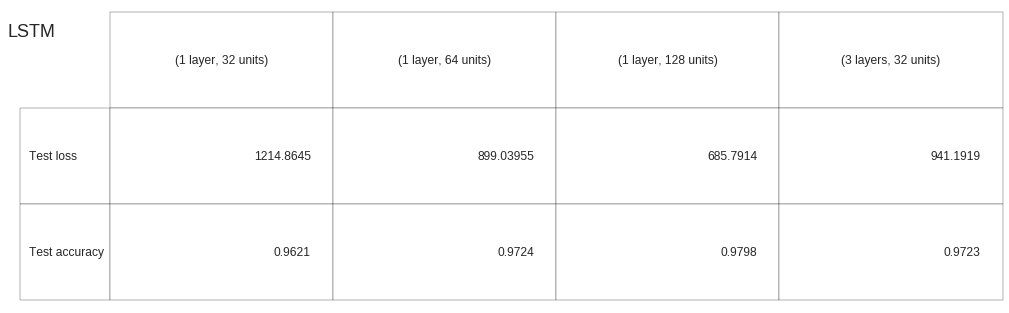

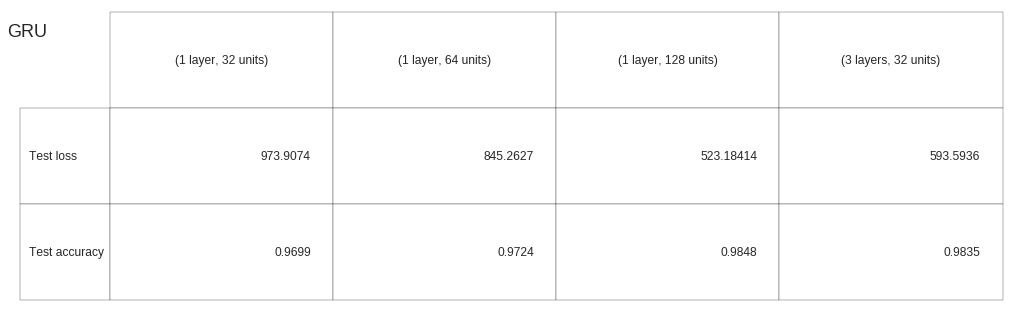

In [ ]:
plot_summary_table(experiment_results)

# Analysis of results

In [ ]:
output_GRU_over_time = np.array(output_GRU)
output_GRU_over_time = output_GRU_over_time[0,:,0,:]
binarized_input_image = np.array(full)
binarized_input_image = binarized_input_image[0,0,:,:] 

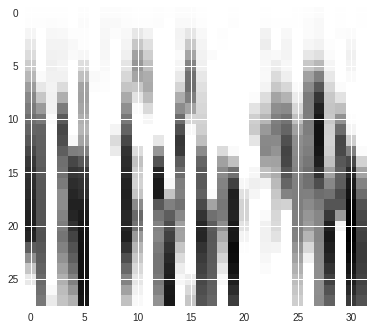

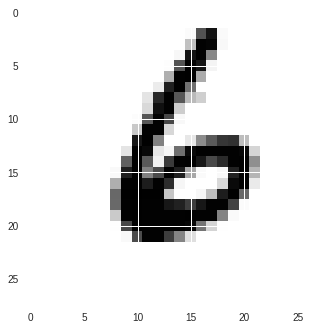

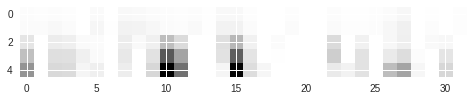

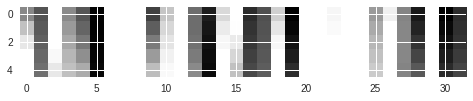

In [ ]:
# Look into the GRU computation over time


# plot one sample over time
plt.imshow(output_GRU_over_time)
plt.show()
plt.imshow(binarized_input_image)
plt.show()
# Feel free to pick a sample from the dataset that more closely supports your 
# answers in Q3.

# first 5 steps in the computation
plt.imshow(output_GRU_over_time[:5,:])
plt.show()
# last 5 steps in the computation
plt.imshow(output_GRU_over_time[-5:,:])
plt.show()

In [ ]:

# Training Parameters
learning_rate = 0.001
num_epochs = 10
batch_size=256
fully_connected_hidden_units=64
num_input = 28
timesteps = 28
num_classes = 10
settings = [(32, 'GRU', 4),(32, 'GRU', -1),(32, 'GRU', -2),(32, 'GRU', -3), (32, 'GRU', -4), (32, 'GRU', -5)]

def GRU_test(x, weights, biases, num_hidden, cell_type, num_layers, output_layer):

    x = tf.unstack(x, timesteps, 1)

    with tf.name_scope('rnn'):
      cell = tf.nn.rnn_cell.MultiRNNCell(
          [cells(cell_type, num_hidden) for _ in range(num_layers)])
      
    outputs, states = tf.nn.static_rnn(cell, x, dtype=tf.float32)
    outputs  = tf.nn.relu(outputs)
    hidden_layer =  tf.nn.relu(tf.matmul(outputs[output_layer], weights['hidden']) + biases['hidden'])
    out = tf.matmul(hidden_layer, weights['out']) + biases['out']
    return out, outputs
  
def cells(cell_type, size):
  if cell_type == "GRU":
    cell = tf.nn.rnn_cell.GRUCell(size)
  elif cell_type == "LSTM":
    cell = tf.nn.rnn_cell.BasicLSTMCell(size)
  return cell

In [ ]:

epochs = 0
with tf.device("/gpu:0"):

  for units, cell, layers in settings:
    mnist = get_data()
    print("Number of RNN units:", units, "  Cell Type:", cell, "  Output Layer:", layers)
    tf.reset_default_graph()
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])


    weights = {
      'hidden': tf.Variable(tf.contrib.layers.xavier_initializer()([units, fully_connected_hidden_units])),
      'out': tf.Variable(tf.contrib.layers.xavier_initializer()([fully_connected_hidden_units, num_classes]))
    }
    biases = {
      'hidden': tf.Variable(tf.contrib.layers.xavier_initializer()([fully_connected_hidden_units])),
      'out': tf.Variable(tf.contrib.layers.xavier_initializer()([num_classes]))
    }

    logits, states = GRU_test(X, weights, biases, units, cell, 1, layers)
    
    prediction = tf.nn.softmax(logits)

    # Define loss and optimizer
    loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float64))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        while mnist.train.epochs_completed < num_epochs:
          
          batch_x, batch_y = mnist.train.next_batch(batch_size)
          batch_x = batch_x.reshape((batch_size, timesteps, num_input))
          sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
          if mnist.train.epochs_completed > epochs:

            loss, sts, acc = sess.run([loss_op, states, accuracy], feed_dict={X: batch_x,
                                                               Y: batch_y})

            print("Epoch {}, Loss = {:.4f}, Training Accuracy = {:.3f}".format(
                mnist.train.epochs_completed, loss, acc))
          epochs = mnist.train.epochs_completed 
          
        test_data = mnist.test.images.reshape((-1, timesteps, num_input))
        test_label = mnist.test.labels
        loss_t, acc_t = sess.run([loss_op, accuracy], feed_dict={X: test_data, 
                                                                 Y: test_label})
        
        print("Testing Accuracy:", \
            acc_t, '\n')



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of RNN units: 32   Cell Type: GRU   Output Layer: 4
Epoch 1, Loss = 467.8308, Training Accuracy = 0.309
Epoch 2, Loss = 470.7102, Training Accuracy = 0.324
Epoch 3, Loss = 456.8329, Training Accuracy = 0.367
Epoch 4, Loss = 451.3842, Training Accuracy = 0.316
Epoch 5, Loss = 435.0717, Training Accuracy = 0.348
Epoch 6, Loss = 453.5015, Training Accuracy = 0.375
Epoch 7, Loss = 435.9677, Training Accuracy = 0.395
Epoch 8, Loss = 452.8171, Training Accuracy = 0.312
Epoch 9, Loss = 426.8704, Training Accuracy = 0.375
Epoch 10, Loss = 409.5049, Training Accuracy = 0.383
Testing Accuracy: 0.3452 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Numbe